# Thesis description

We try to solve a multi agent riddle using Reinforcaement Learning and Neural Networks.

### Inspiration came from 
 - Solving the NSA Periodical Puzzle from [august 2016](https://www.nsa.gov/news-features/puzzles-activities/puzzle-periodical/2016/puzzle-periodical-05.shtml);
 - Deep Mind paper [Learning to Communicate with Deep Multi-Agent Reinforcement Learning](https://arxiv.org/abs/1605.06676).

### Fields related to the thesis: 
  - Reinforcement Learning;
  - Deep Learning.

## N hats problem

Problem to solve:

_On Christmas Eve the prison chief decides to free $n$ prisoners if they all can solve the following task. The jailer has hats of $n$ different colors. He shows all the hat types to the prisoners. On each prisoner's head will be placed a hat of a random color. The captives are placed in a circle. Therefore, each prisoner can see the colors of the hats on the other $n-1$ heads.
    Each prisoner must guess the color of its own hat and write it on a piece of paper. If at least one of them  guesses correctly, all will be released. If not, all will go back to their cells. They are not allowed to say  anything or communicate in any way during the trial. They are allowed to plan a strategy beforehand._
    
#### Summary:
  * There are $n$ prisoners;
  * There are hats of $n$ different colors (the prisoners know how all the hat types look like);
  * On each prisoner's head will be placed a random color hat;
  * Each prisoner will see the colors of the others, but not his own;
  * Each prisoner will make a guess about the hat color on his head;
  * At least one of the guesses must be correct to solve the trial.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### Reinforcement Learning

We model our problem in the [Markov Decision Process (MDP)](https://en.wikipedia.org/wiki/Markov_decision_process) framework in order to use Reinforcement Learning techniques to tackle it.

Each prisoner will be represented by a MDP. The states are what a prisoners sees (a vector of colors). The actions are the colors that a prisoner can choose.

### Analysis of the problem

Because we have $n^n$ possible configurations of hats and each prisoner can perform $n$ actions, the probability of success if each prisoner takes a random action is:

$$1 - \left( \frac{n-1}{n} \right)^ n$$


For $n\to\infty$, the probability of random success goes to $1 - \frac{1}{e} \approx 0.632$.

## Q learning

We try to compute the $Q$ function which tells us how valuable is for an agent to take an action $a$ when he is in state $s \left( Q: States \times Actions \to \mathbb{R} \right)$. Therefore, the first approach is [_Q learning_](https://en.wikipedia.org/wiki/Q-learning).

### Q tables

If $n$ is small, we can use Q tables in order to learn the $Q$ function in each point, but for a large $n$, we must use another approach ($n$ is the number of prisoners. The domain of the Q function has $n^n$ points).

In [2]:
#transform what an agent sees to the number of a row of the Q table
def codify_state(observations, num_agents = 3):
    return sum([num_agents ** y * x for (x,y) in zip(reversed(observations), range(num_agents))])

#inverse of codify
def decodify_state(state, num_agents = 3):
    if state == 0:
        return tuple(num_agents - 1 * [0])
    digits = []
    while state:
        digits += [int(state % num_agents)]
        state /= num_agents
    return tuple(digits[num_agents - 2::-1])

Function to compute the accuracy of the decisions of some prisoners (represented by a list of Q tables)

In [3]:
def test_accuracy(Q_tables):
    number_of_agents = len(Q_tables)
    Q = Q_tables
    reward = 0
    for ep in range(10000):
        hats = [np.random.randint(number_of_agents) for i in range(number_of_agents)]
        states = [codify_state(hats[:i] + hats[i+1:], number_of_agents) for i in range(number_of_agents)]
        
        #take actions accordingly to the Q-tables af each agent for the computed states
        actions = [np.argmax(Q[i][states[i],:]) for i in range(number_of_agents)]

        #verify if the the agents solved the problem
        #(i.e. at least one agent correctly guessed the color of its own hat)
        validate = sum([hats[i] == actions[i] for i in range(number_of_agents)])
        r = 0
        r += 1 if validate >= 1 else 0
        reward += r
    return reward / 10000.


Initializations:

In [6]:
lr             = .1 #Learning rate
num_episodes   = 10 ** 6 #how many time does the update run
min_num_agents = 7 #for how many agents do you want to run the problem first time
num_runs       = 1 #for how many cases to run the simulation (incrementally from min_num_agents)  

Train Q tables for $n \in [2, 5] \cap \mathbb{N}$ ($n$ is the number of prisoners).

In [47]:
batch_accuracies = []
std_deviations   = []
np.random.seed(1)
for j in range(min_num_agents, min_num_agents + num_runs):
    number_of_agents = j
    number_of_states = number_of_agents ** (number_of_agents - 1)
    #Noise function to manage exploration exploitation problem
    def epsilon(episode):
        return np.random.randn(1,number_of_agents)*(1./(episode+1))
    
    #intialize Q Tables:
    Q = np.array([np.random.random([number_of_states, number_of_agents]) for i in range(number_of_agents)])
    r = 0             #Reward at each step
    rewards = 0       #Sum of rewards
    batch_rewards = 0 #Sum of rewards on each 1000 episodes

    batch_accuracy = [test_accuracy(Q)]
    std_deviation  = [np.std([1 if i < int(batch_accuracy[-1] * 1000) else 0 for i in range(1000)])]
    print("######")
    print("Intial accuracy for", j, "agents is: ", test_accuracy(Q))
    
    for ep in range(1, num_episodes):
        
        
        #initialize hats
        hats = [np.random.randint(number_of_agents) for i in range(number_of_agents)]

        #trasform the seen hats into states
        states = [codify_state(hats[:i] + hats[i+1:], number_of_agents) for i in range(number_of_agents)]
               
        #take actions accordingly to the Q-tables af each agent for the computed states
        actions = [np.argmax(Q[i][states[i],:] + epsilon(ep)) for i in range(number_of_agents)]

        #verify if the the agents solved the problem
        #(i.e. at least one agent correctly guessed the color of its own hat)
        validate = sum([hats[i] == actions[i] for i in range(number_of_agents)])
        r += 1 if validate >= 1 else 0 #if the trial was correctly solved, reward = 1 
        
        #update the Q tables acordingly to received reward
        for i in range(number_of_agents):
            Q[i][states[i],actions[i]] = Q[i][states[i],actions[i]] + lr*((2*r - 1) - Q[i][states[i],actions[i]])

                
        #record some obtained reward
        rewards += r
        batch_rewards += r
        r = 0
        #end of a batch
        if(ep % 1000 == 999):
            batch_accuracy.append(batch_rewards / 1000.)
            std_deviation.append(np.std(batch_rewards*[1] + (1000-batch_rewards)*[0]))
            batch_rewards = 0
            
    std_deviations.append(std_deviation)
    batch_accuracies.append(batch_accuracy)
    #batch_accuracy = []
    print("Total rewards on training: {0:d}, out of {1:d} trials;".format(rewards, num_episodes))
    print("Accuracy for", j, "agents after", num_episodes, "episodes is:", test_accuracy(Q))

######
Intial accuracy for 7 agents is:  0.668
Total rewards on training: 677878, out of 1000000 trials;
Accuracy for 7 agents after 1000000 episodes is: 0.681


Save obtained results for nicer plotting:

In [8]:
filename     = "results/statistics/hats_problem/hats_problem_acc&std_1000_ep_{0:d}to{1:d}_prisoners"\
                .format(min_num_agents, min_num_agents + num_runs - 1)
np.savetxt(filename, np.vstack([batch_accuracies, std_deviations]))

In [11]:
np.loadtxt("results/statistics/hats_problem/hats_problem_acc&std_1000_ep_2to6_prisoners")[0]

array([ 0.7479,  0.997 ,  1.    , ...,  1.    ,  1.    ,  1.    ])

Examples of winning $Q$-tables for $n=2$ and $n=3$:

In [134]:
#Do not run this cell
Q.round(2)

array([[[ 0.41,  1.  ],
        [ 1.  ,  0.52]],

       [[ 1.  ,  0.43],
        [ 0.38,  1.  ]]])

In [130]:
#Do not run this cell
Q.round(2)

array([[[ 0.29,  1.  ,  0.3 ],
        [ 0.17,  0.16,  1.  ],
        [ 1.  ,  0.1 ,  0.16],
        [ 0.18,  0.23,  1.  ],
        [-0.  ,  1.  ,  0.06],
        [-0.03,  1.  , -0.06],
        [ 1.  ,  0.28,  0.29],
        [ 0.05,  0.08,  1.  ],
        [ 1.  ,  0.05,  0.07]],

       [[ 0.31,  1.  ,  0.25],
        [ 1.  ,  0.33,  0.31],
        [ 0.07,  1.  ,  0.11],
        [ 0.18,  0.19,  1.  ],
        [ 1.  ,  0.2 ,  0.19],
        [ 0.07,  0.08,  1.  ],
        [ 1.  ,  0.09,  0.14],
        [-0.02,  1.  ,  0.  ],
        [-0.08, -0.15,  1.  ]],

       [[ 1.  ,  0.36,  0.25],
        [ 0.03,  1.  ,  0.11],
        [ 0.39,  1.  ,  0.46],
        [ 0.26,  0.31,  1.  ],
        [ 1.  , -0.02,  0.07],
        [ 0.33,  1.  ,  0.36],
        [ 0.05,  0.07,  1.  ],
        [-0.07, -0.09,  1.  ],
        [ 1.  , -0.1 , -0.08]]])

Quick plots for result inspection. For more plots, see the "results/plots" folder and the notebook from "results" folder.

For training 2 agents (using Q tables), for 100000 episodes, with learning rate 0.1 :
The accuracy started at: 0.7506 and reached: 1.0
For training 3 agents (using Q tables), for 100000 episodes, with learning rate 0.1 :
The accuracy started at: 0.6955 and reached: 1.0
For training 4 agents (using Q tables), for 100000 episodes, with learning rate 0.1 :
The accuracy started at: 0.682 and reached: 0.942
For training 5 agents (using Q tables), for 100000 episodes, with learning rate 0.1 :
The accuracy started at: 0.6657 and reached: 0.811


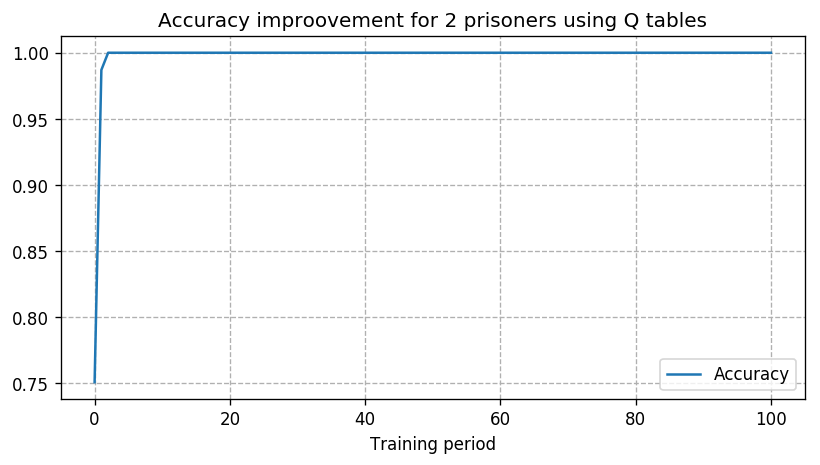

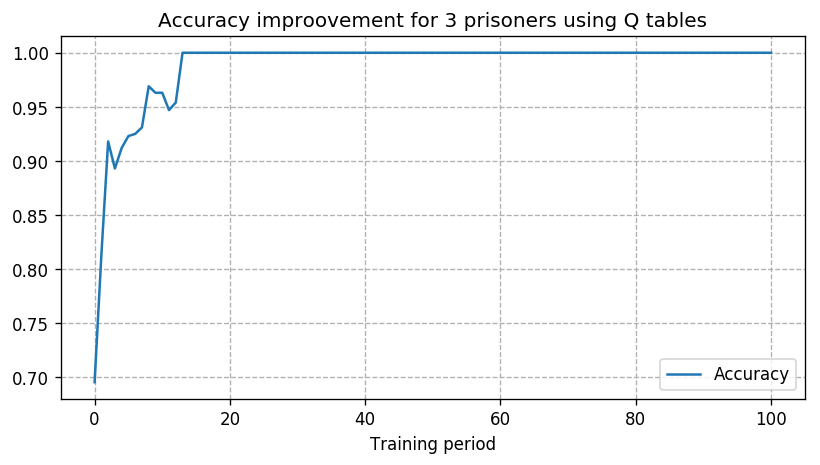

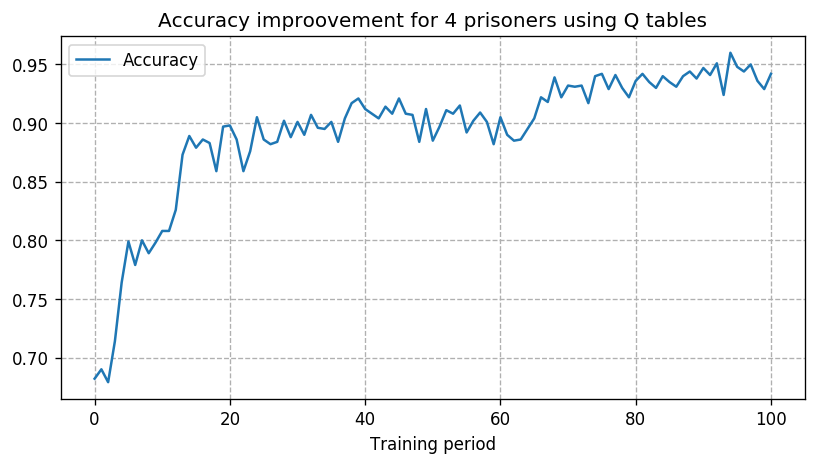

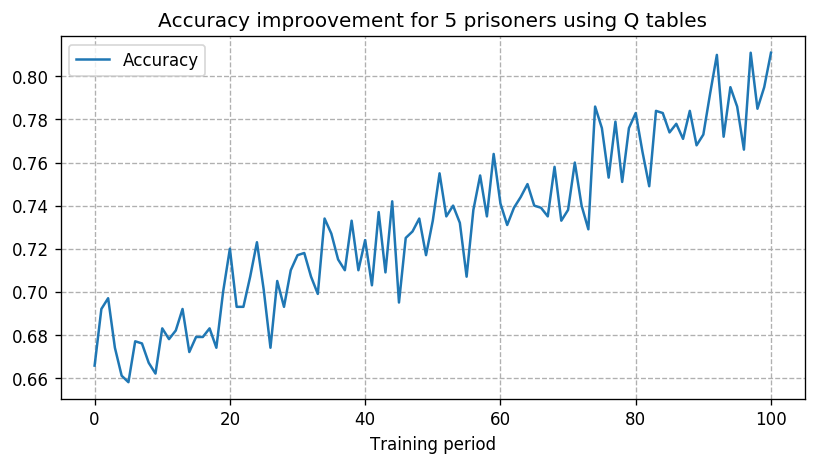

In [8]:
for i in range(len(batch_accuracies)):
    batch_accuracy = batch_accuracies[i]
    plt.figure(figsize=(8, 4), dpi= 120)
    plt.axes()
    plt.title("Accuracy improvement for {0:d} prisoners using Q tables".format(i + 2))
    plt.plot(batch_accuracy, label = "Accuracy")
    plt.yscale("linear")
    plt.xlabel("Training period")
    plt.legend()
    plt.grid(linestyle='--')


    print("For training", i + 2, "agents (using Q tables), for", num_episodes, "episodes, with learning rate", lr, ":")
    print("The accuracy started at:", batch_accuracy[0], "and reached:", batch_accuracy[-1])


As we can see, the accuracy improvement is increasingly slower, as $n$ grows, therefore we do need to improve our method of computing the $Q$ function.

### Q nets 

As well, the number of states increases exponentially with $n$. Therefore, it is unfeasible to compute the $Q$ function in each point (the domain of the Q function has $n^n$ points), therefore we use Q nets to approximate it.

(In [Q learning](https://en.wikipedia.org/wiki/Q-learning), $Q: \mathbb{States} \times \mathbb{Actions} \to \mathbb{R}$ is a function that associates a value to each pair _(state, action)_ ) 

#### Independent Q Learning

The first approach is to train $n$ different networks. Each will represent the thinking of one of the $n$ prisoners. The inputs will be the $n-1$ colors observed by the specific prisoner.

(The second approach will be to train a single network, which will be used by all the prisoners. It will receive the colors of the other agents, but will also have an entry for the index of the prisoner which wants to take the guess. This will highly reduce the number of needed parameters)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


We create a list of nets. One net for each agent. 

In [3]:
#Make lists of NNs components  
models = []
np.random.seed(1)
number_of_agents = 2
for ag in range(number_of_agents):

    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=number_of_agents - 1))
#     model.add(Dense(20, activation='relu'))
#     model.add(Dense(30, activation='relu'))
    model.add(Dense(128, activation='relu'))
#     model.add(Dense(50, activation='relu'))
    model.add(Dense(64, activation='relu'))
#     model.add(Dense(30, activation='relu'))
    model.add(Dense(64, activation='relu'))
#     model.add(Dense(10, activation='relu'))
    model.add(Dense(number_of_agents, activation='sigmoid'))
    model.compile(optimizer='sgd',
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    models.append(model)

In [4]:
print("There are a total of {0:d} trainable parameters."\
      .format(model.count_params() * number_of_agents))

print("The probability of random succes is {0:.2f}."\
      .format(1 - (((number_of_agents - 1) / number_of_agents) ** number_of_agents)))    
    

There are a total of 58628 trainable parameters.
The probability of random succes is 0.75.


In [5]:
def test_accuracy(Q_nets, num_samples=1000):
    number_of_agents = len(Q_nets)
    rAll = 0
    for ep in range(num_samples):
        #initialize hats
        hats = [np.random.randint(number_of_agents) for i in range(number_of_agents)]
        #trasform the seen hats into inputs for the network
        states = [hats[:i] + hats[i+1:] for i in range(number_of_agents)]

        #The Q-Network
        #Take actions in for the agents
        actions = []
        for i in range(number_of_agents):
            state = np.array(states[i]) / number_of_agents #normalize the input

            predictions = models[i].predict( np.reshape(state, (-1, number_of_agents - 1)))
            action      = predictions[0].argmax()
            actions.append((action, predictions[0]))

        validate = sum(actions[x][0] == hats[x] for x in range(number_of_agents))
        r = 0
        r += 1 if validate >= 1 else 0

        rAll += r
    
    return rAll / num_samples

Train the list of Q nets

In [36]:
import sys
import copy
import time
from functools import reduce

# Set learning parameters
e = 0.1
num_episodes = 1 * (10 ** 5)
#create lists to contain total rewards and steps per episode
rList = []
rAll = 0

eta_per_eps = []

for ep in range(num_episodes):
    
    ep_start_time = time.time()
    #initialize hats
    hats = [np.random.randint(number_of_agents) for i in range(number_of_agents)]
    #trasform the seen hats into inputs for the network
    states = [hats[:i] + hats[i+1:] for i in range(number_of_agents)]

    #The Q-Network
    #Take actions in for the agents
    actions = []
    for i in range(number_of_agents):
        state = np.array(states[i]) / number_of_agents #normalize the input
        predictions = models[i].predict( np.reshape(state, (-1, number_of_agents - 1)))
        action      = predictions[0].argmax()
        
        if np.random.rand(1) < e:
            action = np.random.randint(number_of_agents) #env.action_space.sample()
        actions.append((action, predictions[0]))
        
        
    validate = sum(actions[x][0] == hats[x] for x in range(number_of_agents))
    r = 0
    r += 1 if validate >= 1 else 0
    
    
    #update the Q networks
    for i in range(number_of_agents):
        targetQ = [actions[i][1]]
        targetQ[0][actions[i][0]] = .1 if r == 1 else -1
        targetQ = np.reshape(targetQ, (-1, number_of_agents))
        state =  np.reshape(np.array(states[i]) / number_of_agents, (-1, number_of_agents - 1))
        models[i].fit(state, targetQ, verbose=0)
        

    rAll += r
    eta_per_eps.append(time.time() - ep_start_time)
    
    #Update displayed information and epsilon
    if(ep % 200 == 199):
        episode = ep
        winning_episode_percentage = rAll / 200.
        training_percentage = (episode + 1) / num_episodes * 100
        
        sys.stdout.write("\r             Percentage of winning episodes, after {0:d}, out of {1:d} ({2:.2f}%), episodes is {3:.2f}."\
              .format(episode + 1, num_episodes, training_percentage, winning_episode_percentage))
        
        
        #Reduce chance of random action as we train the model.
        e = 1./((ep/10) + 10)

        #Updated accuracy
        rList.append(rAll / 200.)
        rAll = 0 
        
        #Print estimated time 
        eta_seconds = int(((sum(eta_per_eps[-30:]) / 30) * (num_episodes - episode)))
        eta_hours   = eta_seconds // 3600
        eta_minutes = (eta_seconds % 3600) // 60
        eta_seconds = eta_seconds % 60
        sys.stdout.write("\r ETA: {0:0d}:{1:0d}:{2:0d}.".format(eta_hours, eta_minutes, eta_seconds))
 


 ETA: 0:0:0. Percentage of winning episodes, after 100000, out of 100000 (100.00%), episodes is 1.00.

In [37]:
test_accuracy(models)

1.0

In [38]:
filename     = "results/statistics/hats_problem/hats_problem_average_200_winning_percentage_QNets_{0:d}"\
                .format(number_of_agents)

np.savetxt("hats_problem_average_200_winning_percentage_QNets_2",rList)

Plot preliminary results for using Q nets

For training 2 agents (using Q nets), for 100000 episodes,
the accuracy started at: 0.835 and reached: 1.0


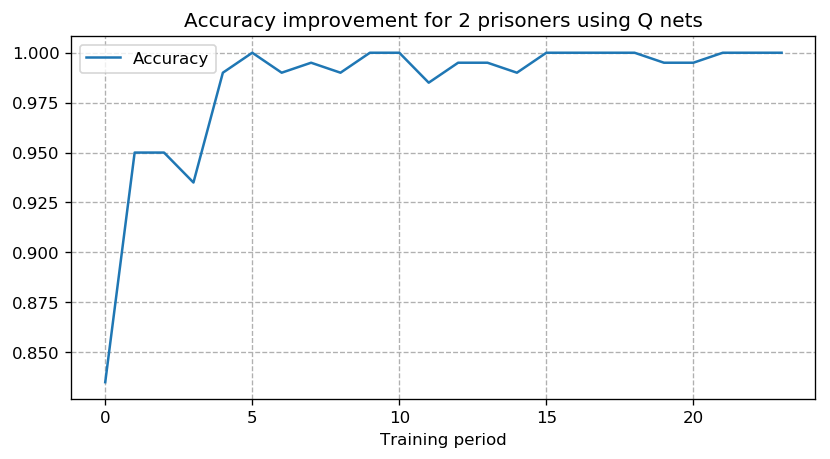

In [20]:
batch_accuracy = rList
plt.figure(figsize=(8, 4), dpi= 120)
plt.axes()
plt.title("Accuracy improvement for {0:d} prisoners using Q nets".format(number_of_agents))
plt.plot(batch_accuracy, label = "Accuracy")
plt.yscale("linear")
plt.xlabel("Training period")
plt.legend()
plt.grid(linestyle='--')


print("For training", number_of_agents, "agents (using Q nets), for", num_episodes, "episodes,")
print("the accuracy started at:", batch_accuracy[0], "and reached:", batch_accuracy[-1])
